In [1]:
import cv2
import numpy as np
import tensorflow as tf

img = cv2.imread("test3.jpg", cv2.IMREAD_COLOR)
#print(color)

In [2]:
model1 = tf.keras.models.load_model('model_1.h5')
model2 = tf.keras.models.load_model('model_2.h5')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [0]:
def get_center(img):
    x,y,_ = np.shape(img)
    n = x//2
    m = y//2
    x_ = x//10
    y_ = y//10
    new = img[n-x_:n+x_, m-y_:m+y_]
    return new

In [0]:
def mask(img):
    r=1
    y=1
    g=1
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    lower_red = np.array([161, 155, 84]) 
    upper_red = np.array([179, 255, 255])
    lower_green = np.array([25, 52, 72]) 
    upper_green = np.array([102, 255, 255])
    lower_yellow = np.array([10,100,20])
    upper_yellow = np.array([25,255,255])
    red_mask = cv2.inRange(hsv, lower_red, upper_red)
    red = cv2.bitwise_and(img, img, mask=red_mask)
    green_mask = cv2.inRange(hsv, lower_green, upper_green)
    green = cv2.bitwise_and(img, img, mask=green_mask)
    yellow_mask = cv2.inRange(hsv, lower_yellow, upper_yellow)
    yellow = cv2.bitwise_and(img, img, mask=yellow_mask)
    if np.sum(red)==0 or np.sum(red)<np.sum(green) or np.sum(red)<np.sum(yellow):
        r=0
    if np.sum(green)==0 or np.sum(green)<np.sum(yellow) or np.sum(green)<np.sum(red):
        g=0
    if np.sum(yellow)==0 or np.sum(yellow)<np.sum(green) or np.sum(yellow)<np.sum(red):
        y=0
    return r,y,g

In [0]:
import matplotlib.pyplot as plt
def segment(img,model,model_2,segment_size):
    n, m = segment_size
    x, y, _ = np.shape(img)
    predict = []
    k = 0
    f = False
    for i in range(0,x-n+1,50):
        if k>15:
            break
        for j in range(0,y-m+1,50):
            new = img[i:i+n, j:j+m,:]
            new1 = new
            new = np.resize(new, (1, 299, 299, 3))
            res = model.predict(new)
            if np.argmax(res)==2 or np.argmax(res)==1:
                f = True
                res = model_2.predict(new)
                p = np.argmax(res)
                predict.append([p,i,j])
                new = np.resize(new,(200,200))
                plt.imshow(new1)
                plt.show()
            else:
                continue
        if f:
          k = k+1
    return predict

In [0]:
def direction(predict, segment_size, img):
    # label_1 -> (None,light_0,light_1)
    # label_2 -> (left,right,straight,full,u)
    if not predict:
      return None
    n, m = segment_size
    x, y, _ = np.shape(img)
    left = [x,y]
    right = [x,y]
    straight = [x,y]
    full = [x,y]
    u = [x,y]
    active = [False,False,False,False,False]#left,right,straight,full,u
    for j in range(len(predict)):
      p = predict[j][0]
      i= predict[j][1]
      if p==0 and i*n<left[0] and not active[0]:
        left[0] = i*n
        left[1] = j*m
        active[0] = True
        continue
      if p==1 and i*n<right[0] and not active[1]:
        right[0] = i*n
        right[1] = j*m
        active[1] = True
        continue
      if p==2 and i*n<straight[0] and not active[2]:
        straight[0] = i*n
        straight[1] = j*m
        active[2] = True
        continue
      if p==3 and i*n<full[0] and not active[3]:
        full[0] = i*n
        full[1] = j*m
        active[3] = True
        continue
      if p==4 and i*n<u[0] and not active[4]:
        u[0] = i*n
        u[1] = j*m
        active[4] = True
        continue
      if np.sum(active)==5:
        break
    direction = [False,False,False,False,False]#left,right,front,U,wait
    #region = []
    if active[3] and full[0]<u[0] and full[0]<straight[0] and full[0]<right[0] and full[0]<left[0]:
        new = img[full[0]:full[0]+n, full[1]:full[1]+m]
        new = get_center(new)
        r,y,g = mask(new)
        #region.append([full])
        if r==1:
            return direction
        elif y==1:
            direction[4] = True
            return direction
        else:
            direction = [True,True,True,True,False]
            return direction
    if active[0]:
        new = img[left[0]:left[0]+n, left[1]:left[1]+m]
        new = get_center(new)
        r,y,g = mask(new)
        #region.append([left])
        if r==1:
            direction[0] = False
        elif y==1:
            direction[4] = True
        else:
            direction[0] = True
    if active[1]:
        new = img[right[0]:right[0]+n, right[1]:right[1]+m]
        new = get_center(new)
        r,y,g = mask(new)
        #region.append([right])
        if r==1:
            direction[1] = False
        elif y==1:
            direction[4] = True
        else:
            direction[1] = True
    if active[2]:
        new = img[straight[0]:straight[0]+n, straight[1]:straight[1]+m]
        new = get_center(new)
        r,y,g = mask(new)
        #region.append([straight])
        if r==1:
            direction[2] = False
        elif y==1:
            direction[4] = True
        else:
            direction[2] = True
    if active[4]:
        new = img[u[0]:u[0]+n, u[1]:u[1]+m]
        new = get_center(new)
        r,y,g = mask(new)
        #region.append([u])
        if r==1:
            direction[3] = False
        elif y==1:
            direction[4] = True
        else:
            direction[3] = True
    return direction

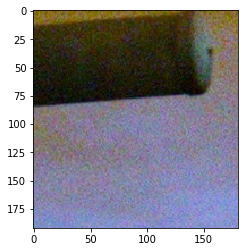

In [0]:
segment_size = [192, 181]
predict = segment(img, model1, model2, segment_size)
print(len(predict))

In [0]:
direction = direction(predict, segment_size, img)

print(direction)
#print(np.size(region))
#print(region)

TypeError: ignored